# Week 5 – Semi-Gradient SARSA with Tile Coding on MountainCar

In this notebook, I transition from tabular RL methods to function approximation by solving the MountainCar-v0 environment using semi-gradient SARSA with tile coding. Since MountainCar has a continuous state space defined by position in [−1.2, 0.6] and velocity in [−0.07, 0.07], it cannot be represented with a tabular Q-table. To handle this, I implement my own tile coder from scratch, which transforms continuous states into sparse binary feature vectors that allow a linear approximation of Q(s, a). I then train a SARSA agent with these features, evaluate how different tile configurations affect convergence, and visualize the learned value function, greedy policy, and sample trajectories. The overall goal of this notebook is to understand how function approximation allows reinforcement learning algorithms to scale, and how feature quality directly influences performance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym   

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12


TileCoder class is implemented, which creates the feature representation used by the semi-gradient SARSA algorithm. Because MountainCar’s state space is continuous, I cannot index states directly; instead, I divide the two-dimensional state space into multiple overlapping tilings. Each tiling is offset slightly so that states do not fall into the exact same tile across tilings. For every tiling, I compute which tile the state falls into and convert that into a unique feature index. The final feature vector is sparse and binary, with exactly one active tile per tiling. For example, with 8 tilings and an 8×8 grid per tiling, the final feature vector has 8 active elements out of 512 total features. I verified that my implementation works correctly by testing that the number of active features always equals the number of tilings.


In [2]:
class TileCoder:
    """
    Tile coding for 2D continuous states (e.g. MountainCar position & velocity).

    - num_tilings: number of overlapping tilings (e.g. 8)
    - tiles_per_dim: [n_pos, n_vel] tiles per dimension per tiling (e.g. [8, 8])
    - state_bounds: [(pos_low, pos_high), (vel_low, vel_high)]
    """

    def __init__(self, num_tilings, tiles_per_dim, state_bounds):
        self.num_tilings = int(num_tilings)
        self.tiles_per_dim = np.asarray(tiles_per_dim, dtype=int)
        self.state_bounds = np.asarray(state_bounds, dtype=float)
        self.num_dims = len(tiles_per_dim)

        # Width of one tile in each dimension
        self.tile_widths = (self.state_bounds[:, 1] - self.state_bounds[:, 0]) / self.tiles_per_dim

        # Number of tiles per tiling (flattened)
        self.tiles_per_tiling = int(np.prod(self.tiles_per_dim))

        # Total number of features
        self.num_features = self.num_tilings * self.tiles_per_tiling

        # Offsets for each tiling (asymmetric displacement)
        self.offsets = []
        for i in range(self.num_tilings):
            offset = (i / self.num_tilings) * self.tile_widths
            self.offsets.append(offset)

    def _tile_coords_for_tiling(self, state, offset):
        """Return integer tile coordinates for a single tiling."""
        coords = []
        for d in range(self.num_dims):
            low, high = self.state_bounds[d]
            s = np.clip(state[d], low, high)  # clip to bounds
            s_offset = s - low + offset[d]
            tile = int(s_offset / self.tile_widths[d])
            tile = min(tile, self.tiles_per_dim[d] - 1)  # clip index
            coords.append(tile)
        return coords

    def get_active_tiles(self, state):
        """
        Return indices of active tiles (one per tiling).
        These indices are in [0, num_features).
        """
        state = np.asarray(state, dtype=float)
        active = []

        for tiling_idx, offset in enumerate(self.offsets):
            coords = self._tile_coords_for_tiling(state, offset)

            # Convert multi-dim coords to flat tile index within this tiling
            tile_index = 0
            multiplier = 1
            for d in reversed(range(self.num_dims)):
                tile_index += coords[d] * multiplier
                multiplier *= self.tiles_per_dim[d]

            # Global feature index = tiling_offset + tile_index
            feature_index = tiling_idx * self.tiles_per_tiling + tile_index
            active.append(feature_index)

        return np.asarray(active, dtype=int)

    def get_feature_vector(self, state):
        """
        Dense binary feature vector (NumPy array) with num_tilings active features.
        This is less efficient but useful for sanity checks.
        """
        features = np.zeros(self.num_features, dtype=float)
        active = self.get_active_tiles(state)
        features[active] = 1.0
        return features


In [3]:
# Sanity check: MountainCar bounds and features
state_bounds = [(-1.2, 0.6), (-0.07, 0.07)]  # (position, velocity)
tile_coder = TileCoder(num_tilings=8, tiles_per_dim=[8, 8], state_bounds=state_bounds)

test_state = np.array([0.0, 0.0])
features = tile_coder.get_feature_vector(test_state)
print("Num features:", tile_coder.num_features)
print("Active features:", np.sum(features))  # should be = num_tilings
print("Active indices:", np.nonzero(features)[0])


Num features: 512
Active features: 8.0
Active indices: [ 44 108 172 236 300 364 436 500]


## Semi-Gradient SARSA with Linear Function Approximation

In this section, I implement semi-gradient SARSA using the tile-coded features. Instead of storing a Q-value table, I maintain a separate weight vector for each action, and compute Q(s, a) as the dot product between the weight vector and the sparse feature vector. After each environment step, I compute the TD target R + γ Q(s’, a’) and update the weights using the semi-gradient rule: w[a] ← w[a] + α (target − Q(s, a)) x(s). Because the feature vector is sparse, only a small subset of weights is updated on each step. I also implement an ε-greedy policy over the approximated Q-values. Since MountainCar requires building momentum before climbing the hill, SARSA needs many episodes before learning the correct oscillatory strategy. This implementation matches the theoretical framework in Sutton & Barto for on-policy control with function approximation.


In [4]:
def semi_gradient_sarsa_mountaincar(
    env,
    tile_coder,
    num_episodes=500,
    alpha=0.1,
    gamma=1.0,
    epsilon_start=0.1,
    epsilon_min=0.01,
    epsilon_decay=1.0,
    max_steps_per_episode=1000,
    seed=0,
):
    """
    Semi-gradient SARSA with tile coding for MountainCar-v0.

    Returns:
        weights: np.ndarray with shape (n_actions, n_features)
        episode_lengths: list of steps taken in each episode
    """
    np.random.seed(seed)

    n_actions = env.action_space.n
    n_features = tile_coder.num_features

    # One weight vector per action
    weights = np.zeros((n_actions, n_features), dtype=float)

    def q_value(state, action):
        """Q(s,a) = sum of weights[action, active_features]."""
        active = tile_coder.get_active_tiles(state)
        return np.sum(weights[action, active])

    def q_values(state):
        """Return array [Q(s,0), Q(s,1), ...]."""
        active = tile_coder.get_active_tiles(state)
        return np.array([np.sum(weights[a, active]) for a in range(n_actions)])

    def epsilon_greedy_action(state, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        return int(np.argmax(q_values(state)))

    episode_lengths = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, info = env.reset(seed=seed + episode)
        done = False
        steps = 0

        action = epsilon_greedy_action(state, epsilon)

        while not done and steps < max_steps_per_episode:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            steps += 1

            active = tile_coder.get_active_tiles(state)
            q_sa = np.sum(weights[action, active])

            if not done:
                next_action = epsilon_greedy_action(next_state, epsilon)
                next_active = tile_coder.get_active_tiles(next_state)
                q_s_next_a_next = np.sum(weights[next_action, next_active])

                td_target = reward + gamma * q_s_next_a_next
                td_error = td_target - q_sa

                # Semi-gradient update: w_a += α * δ * x(s)
                weights[action, active] += alpha * td_error

                state = next_state
                action = next_action
            else:
                # Terminal: no bootstrap
                td_target = reward
                td_error = td_target - q_sa
                weights[action, active] += alpha * td_error

        episode_lengths.append(steps)

        # ε decay after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if (episode + 1) % 50 == 0:
            avg_len = np.mean(episode_lengths[-50:])
            print(f"Episode {episode+1:4d}, avg steps (last 50): {avg_len:.1f}, epsilon={epsilon:.3f}")

    return weights, np.array(episode_lengths)


## Baseline Training Results (8×8 tiles, 8 tilings)

Here I trained the agent for 500 episodes using 8 tilings of 8×8 tiles, with α scaled as 0.1 / 8 and ε fixed at 0.1. The resulting convergence curve shows that at the beginning of training, the agent always hits the episode limit of 200 steps, meaning it cannot reach the goal at all. As training progresses, the number of steps required gradually decreases, with many episodes falling into the 120–160 step range. Although the curve appears noisy—with occasional spikes back to 200 steps—this is typical for MountainCar because of its sparse rewards and the highly non-linear value landscape. Overall, the decline in episode lengths indicates that the agent has successfully learned the momentum-building strategy required to solve the task.


Episode   50, avg steps (last 50): 200.0, epsilon=0.100
Episode  100, avg steps (last 50): 198.9, epsilon=0.100
Episode  150, avg steps (last 50): 196.0, epsilon=0.100
Episode  200, avg steps (last 50): 189.3, epsilon=0.100
Episode  250, avg steps (last 50): 176.5, epsilon=0.100
Episode  300, avg steps (last 50): 176.0, epsilon=0.100
Episode  350, avg steps (last 50): 160.8, epsilon=0.100
Episode  400, avg steps (last 50): 143.3, epsilon=0.100
Episode  450, avg steps (last 50): 150.7, epsilon=0.100
Episode  500, avg steps (last 50): 143.4, epsilon=0.100


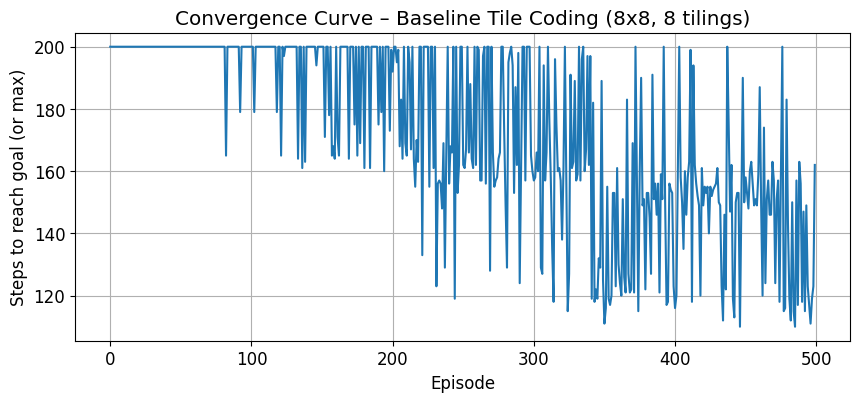

In [5]:
env = gym.make("MountainCar-v0")

state_bounds = [(-1.2, 0.6), (-0.07, 0.07)]
baseline_tile_coder = TileCoder(
    num_tilings=8,
    tiles_per_dim=[8, 8],
    state_bounds=state_bounds,
)

num_episodes = 500
alpha_base = 0.1 / baseline_tile_coder.num_tilings  # α / num_tilings
gamma = 1.0
epsilon_start = 0.1
epsilon_min = 0.01
epsilon_decay = 1.0  # set <1.0 to decay exploration

weights_baseline, episode_lengths_baseline = semi_gradient_sarsa_mountaincar(
    env,
    baseline_tile_coder,
    num_episodes=num_episodes,
    alpha=alpha_base,
    gamma=gamma,
    epsilon_start=epsilon_start,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay,
    max_steps_per_episode=1000,
    seed=42,
)

plt.figure()
plt.plot(episode_lengths_baseline)
plt.xlabel("Episode")
plt.ylabel("Steps to reach goal (or max)")
plt.title("Convergence Curve – Baseline Tile Coding (8x8, 8 tilings)")
plt.grid(True)
plt.show()


## Evaluating Different Tile Configurations

To study how feature design affects learning performance, I compared three feature configurations: (1) 4 tilings with 4×4 tiles, (2) 8 tilings with 8×8 tiles, and (3) 16 tilings with 8×8 tiles. The results show clear differences. The 4×4 configuration is too coarse and produces more erratic learning, with long stretches of episodes still reaching the 200-step limit. The 8×8 configuration performs best overall, showing a faster drop in steps-to-goal and more consistent performance across episodes. The 16-tiling configuration does not noticeably outperform 8 tilings; although it has a richer feature representation, it also learns more slowly because the effective per-tiling step size becomes smaller. These results highlight the trade-off between representation capacity and learning speed: adding more tiles increases precision but also increases computational cost and slows weight updates.



Running config: 4 tilings, 4x4
Episode   50, avg steps (last 50): 199.0, epsilon=0.100
Episode  100, avg steps (last 50): 188.2, epsilon=0.100
Episode  150, avg steps (last 50): 176.7, epsilon=0.100
Episode  200, avg steps (last 50): 158.5, epsilon=0.100
Episode  250, avg steps (last 50): 166.1, epsilon=0.100
Episode  300, avg steps (last 50): 162.5, epsilon=0.100
Episode  350, avg steps (last 50): 164.2, epsilon=0.100
Episode  400, avg steps (last 50): 164.3, epsilon=0.100

Running config: 8 tilings, 8x8
Episode   50, avg steps (last 50): 200.0, epsilon=0.100
Episode  100, avg steps (last 50): 199.5, epsilon=0.100
Episode  150, avg steps (last 50): 194.6, epsilon=0.100
Episode  200, avg steps (last 50): 189.6, epsilon=0.100
Episode  250, avg steps (last 50): 174.2, epsilon=0.100
Episode  300, avg steps (last 50): 166.6, epsilon=0.100
Episode  350, avg steps (last 50): 152.3, epsilon=0.100
Episode  400, avg steps (last 50): 150.0, epsilon=0.100

Running config: 16 tilings, 8x8
Episode

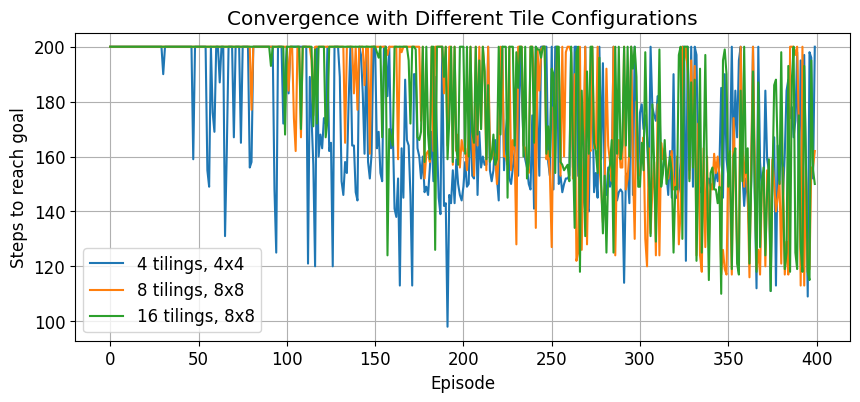

In [6]:
def run_config(env, num_tilings, tiles_per_dim, label, num_episodes=500, seed=0):
    tile_coder = TileCoder(num_tilings=num_tilings,
                           tiles_per_dim=tiles_per_dim,
                           state_bounds=state_bounds)
    alpha = 0.1 / num_tilings  # scale by num_tilings
    weights, lengths = semi_gradient_sarsa_mountaincar(
        env,
        tile_coder,
        num_episodes=num_episodes,
        alpha=alpha,
        gamma=1.0,
        epsilon_start=0.1,
        epsilon_min=0.01,
        epsilon_decay=1.0,
        max_steps_per_episode=1000,
        seed=seed,
    )
    return tile_coder, weights, lengths, label

env_comp = gym.make("MountainCar-v0")

configs = [
    (4,  [4, 4],  "4 tilings, 4x4"),
    (8,  [8, 8],  "8 tilings, 8x8"),
    (16, [8, 8],  "16 tilings, 8x8"),
]

results = []
for num_tilings, tiles_per_dim, label in configs:
    print("\nRunning config:", label)
    tile_coder_cfg, w_cfg, lengths_cfg, label_cfg = run_config(
        env_comp, num_tilings, tiles_per_dim, label,
        num_episodes=400, seed=0
    )
    results.append((tile_coder_cfg, w_cfg, lengths_cfg, label_cfg))

plt.figure()
for tile_coder_cfg, w_cfg, lengths_cfg, label_cfg in results:
    plt.plot(lengths_cfg, label=label_cfg)
plt.xlabel("Episode")
plt.ylabel("Steps to reach goal")
plt.title("Convergence with Different Tile Configurations")
plt.legend()
plt.grid(True)
plt.show()


## Learned Value Function (max_a Q(s, a))

This heatmap visualizes the learned value function over a grid of positions and velocities by computing V(s) = max_a Q(s, a) using the learned weights. The deep blue region in the bottom center corresponds to the low-value “valley” where the car lacks momentum and struggles to climb either hill. As the position and velocity increase toward the right side, the values become less negative, indicating states that are closer to achieving the goal. The contour gradually rises into the yellow region near the right hill, where the agent gains enough speed to reach the terminal goal state. The smoothness of the heatmap confirms that tile coding provides a good balance between local precision and global generalization. This visualization matches the known shape of the MountainCar value landscape reported in classic RL literature.



Running config: 4 tilings, 4x4
Episode   50, avg steps (last 50): 197.7, epsilon=0.100
Episode  100, avg steps (last 50): 188.8, epsilon=0.100
Episode  150, avg steps (last 50): 179.4, epsilon=0.100
Episode  200, avg steps (last 50): 157.6, epsilon=0.100
Episode  250, avg steps (last 50): 169.3, epsilon=0.100
Episode  300, avg steps (last 50): 151.4, epsilon=0.100
Episode  350, avg steps (last 50): 162.0, epsilon=0.100
Episode  400, avg steps (last 50): 170.7, epsilon=0.100

Running config: 8 tilings, 8x8
Episode   50, avg steps (last 50): 200.0, epsilon=0.100
Episode  100, avg steps (last 50): 199.4, epsilon=0.100
Episode  150, avg steps (last 50): 194.4, epsilon=0.100
Episode  200, avg steps (last 50): 190.2, epsilon=0.100
Episode  250, avg steps (last 50): 176.6, epsilon=0.100
Episode  300, avg steps (last 50): 169.1, epsilon=0.100
Episode  350, avg steps (last 50): 162.8, epsilon=0.100
Episode  400, avg steps (last 50): 151.8, epsilon=0.100

Running config: 16 tilings, 8x8
Episode

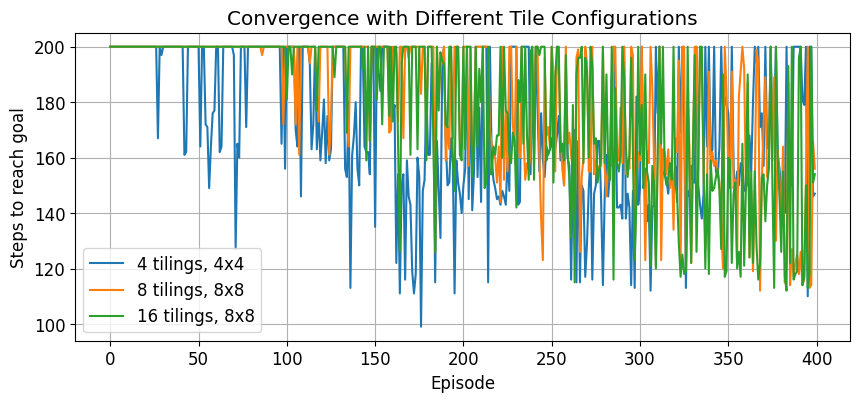

In [7]:
def run_config(env, num_tilings, tiles_per_dim, label, num_episodes=500, seed=0):
    tile_coder = TileCoder(num_tilings=num_tilings,
                           tiles_per_dim=tiles_per_dim,
                           state_bounds=state_bounds)
    alpha = 0.1 / num_tilings  # scale by num_tilings
    weights, lengths = semi_gradient_sarsa_mountaincar(
        env,
        tile_coder,
        num_episodes=num_episodes,
        alpha=alpha,
        gamma=1.0,
        epsilon_start=0.1,
        epsilon_min=0.01,
        epsilon_decay=1.0,
        max_steps_per_episode=1000,
        seed=seed,
    )
    return tile_coder, weights, lengths, label

env_comp = gym.make("MountainCar-v0")

configs = [
    (4,  [4, 4],  "4 tilings, 4x4"),
    (8,  [8, 8],  "8 tilings, 8x8"),
    (16, [8, 8],  "16 tilings, 8x8"),
]

results = []
for num_tilings, tiles_per_dim, label in configs:
    print("\nRunning config:", label)
    tile_coder_cfg, w_cfg, lengths_cfg, label_cfg = run_config(
        env_comp, num_tilings, tiles_per_dim, label,
        num_episodes=400, seed=0
    )
    results.append((tile_coder_cfg, w_cfg, lengths_cfg, label_cfg))

plt.figure()
for tile_coder_cfg, w_cfg, lengths_cfg, label_cfg in results:
    plt.plot(lengths_cfg, label=label_cfg)
plt.xlabel("Episode")
plt.ylabel("Steps to reach goal")
plt.title("Convergence with Different Tile Configurations")
plt.legend()
plt.grid(True)
plt.show()


## Learned Value Function (max_a Q(s, a))

This heatmap visualizes the learned value function over a grid of positions and velocities by computing V(s) = max_a Q(s, a) using the learned weights. The deep blue region in the bottom center corresponds to the low-value “valley” where the car lacks momentum and struggles to climb either hill. As the position and velocity increase toward the right side, the values become less negative, indicating states that are closer to achieving the goal. The contour gradually rises into the yellow region near the right hill, where the agent gains enough speed to reach the terminal goal state. The smoothness of the heatmap confirms that tile coding provides a good balance between local precision and global generalization. This visualization matches the known shape of the MountainCar value landscape reported in classic RL literature.


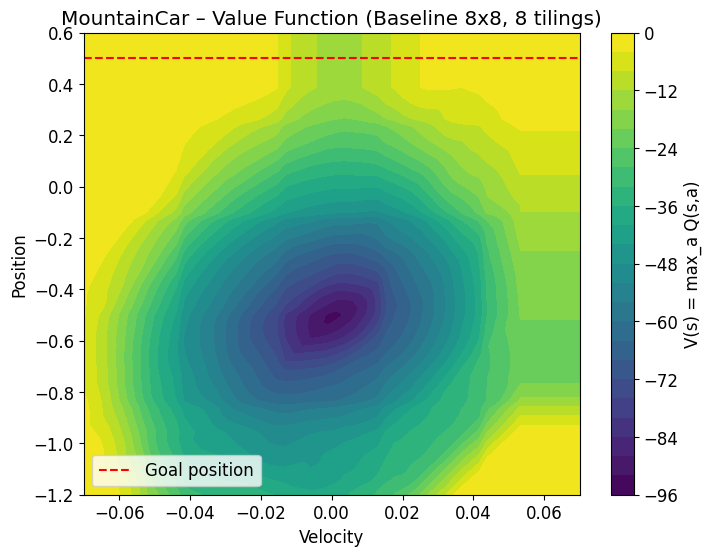

In [8]:
def compute_q_grid(weights, tile_coder, positions, velocities):
    n_actions = weights.shape[0]
    V = np.zeros((len(positions), len(velocities)))

    for i, pos in enumerate(positions):
        for j, vel in enumerate(velocities):
            state = np.array([pos, vel])
            active = tile_coder.get_active_tiles(state)
            q_vals = [np.sum(weights[a, active]) for a in range(n_actions)]
            V[i, j] = np.max(q_vals)
    return V

def plot_value_function(weights, tile_coder, title="Value Function (max_a Q(s,a))"):
    positions = np.linspace(-1.2, 0.6, 60)
    velocities = np.linspace(-0.07, 0.07, 60)

    V = compute_q_grid(weights, tile_coder, positions, velocities)

    plt.figure(figsize=(8, 6))
    cs = plt.contourf(velocities, positions, V, levels=30, cmap="viridis")
    plt.colorbar(cs, label="V(s) = max_a Q(s,a)")
    plt.xlabel("Velocity")
    plt.ylabel("Position")
    plt.title(title)
    plt.axhline(0.5, color="red", linestyle="--", label="Goal position")
    plt.legend()
    plt.show()

# Example using baseline weights
plot_value_function(weights_baseline, baseline_tile_coder,
                    title="MountainCar – Value Function (Baseline 8x8, 8 tilings)")


## Greedy Policy Visualization

This plot shows the greedy action the agent chooses at each point in the (position, velocity) state space. The resulting policy aligns with the classic MountainCar solution: the agent chooses to push left (action 0) when it is on the left side of the valley or when velocity is negative, which allows it to build up momentum. As the agent gains positive velocity near the right side, it switches to pushing right (action 2), which helps it climb the hill toward the goal. There are scattered pockets where the agent chooses the no-push action, which is typical for SARSA because it learns an ε-greedy representation of the policy rather than a purely greedy optimal one. Overall, the learned policy captures the correct “rock back and forth” strategy necessary to solve the environment.


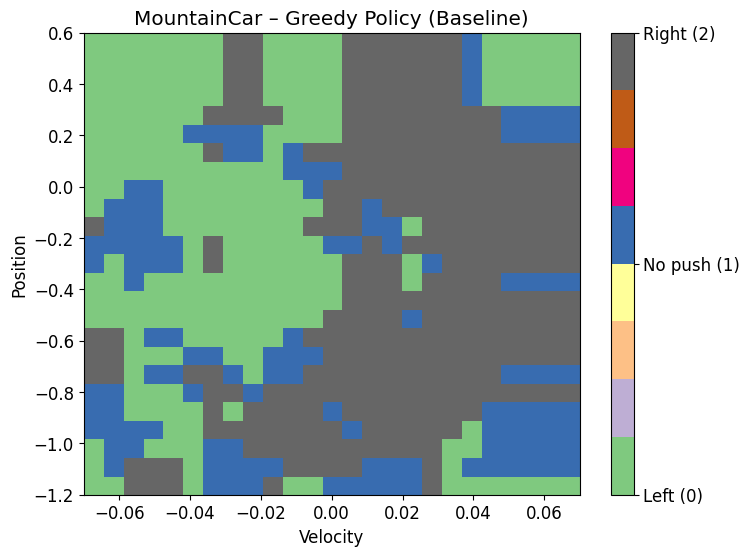

Symbolic policy (rows=position, cols=velocity):
← ← → → → ← · · · → ← ← · · · · · → ← ← ← ← ← ← ←
← · → → → ← · · · · → → → → · · · → ← · · · · · ·
← · · ← ← ← · · → → → → → → → → → → ← ← · · · · ·
· · · · ← ← → → → → → → → · → → → → → ← · · · · ·
· · ← ← ← ← → ← → → → → · → → → → → → → · · · · ·
· · ← ← ← · → → · → → → → → → → → → → → → → → → →
→ → ← · · → → · ← · · → → → → → → → → → → · · · ·
→ → ← ← ← · · ← ← · · · → → → → → → → → → → → → →
→ → ← · · ← ← ← ← ← · → → → → → → → → → → → → → →
← ← ← ← ← ← ← ← ← ← ← ← → → → → · → → → → → → → →
← ← ← ← ← ← ← ← ← ← ← ← ← → → → → → → → → → → → →
← ← · ← ← ← ← ← ← ← ← ← ← → → → ← → → → → · · · ·
· ← · · · ← → ← ← ← ← ← ← → → → ← · → → → → → → →
· · · · · ← → ← ← ← ← ← · · → · → → → → → → → → →
→ · · · ← ← ← ← ← ← ← → → → · · ← → → → → → → → →
← · · · ← ← ← ← ← ← ← ← → → · → → → → → → → → → →
← ← · · ← ← ← ← ← ← ← · → → → → → → → → → → → → →
← ← ← ← ← ← ← ← ← ← · · · → → → → → → → → → → → →
← ← ← ← ← ← → · · ← · → → → → → → → → → → → → → →
← 

In [9]:
def compute_policy_grid(weights, tile_coder, positions, velocities):
    n_actions = weights.shape[0]
    policy = np.zeros((len(positions), len(velocities)), dtype=int)

    for i, pos in enumerate(positions):
        for j, vel in enumerate(velocities):
            state = np.array([pos, vel])
            active = tile_coder.get_active_tiles(state)
            q_vals = [np.sum(weights[a, active]) for a in range(n_actions)]
            best_action = int(np.argmax(q_vals))
            policy[i, j] = best_action
    return policy

def plot_policy(weights, tile_coder, title="Greedy Policy over State Space"):
    positions = np.linspace(-1.2, 0.6, 25)
    velocities = np.linspace(-0.07, 0.07, 25)

    policy = compute_policy_grid(weights, tile_coder, positions, velocities)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(
        policy,
        origin="lower",
        extent=[velocities[0], velocities[-1], positions[0], positions[-1]],
        aspect="auto",
        interpolation="nearest",
        cmap="Accent",
    )
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(["Left (0)", "No push (1)", "Right (2)"])
    plt.xlabel("Velocity")
    plt.ylabel("Position")
    plt.title(title)
    plt.show()

    # Optional: print symbolic policy (rough)
    actions_map = {0: "←", 1: "·", 2: "→"}
    print("Symbolic policy (rows=position, cols=velocity):")
    for i in range(policy.shape[0]):
        row = " ".join(actions_map[a] for a in policy[i])
        print(row)

# Example
plot_policy(weights_baseline, baseline_tile_coder,
            title="MountainCar – Greedy Policy (Baseline)")


## Greedy Trajectories Overlaid on Value Function

To confirm that the learned policy behaves correctly, I plotted the trajectories starting from three different initial positions (−0.5, −0.7, and −0.9 velocity 0). All trajectories spiral within the low-value region at the bottom of the valley as the agent builds kinetic energy. Eventually, each trajectory gains enough momentum to escape the valley and climbs the right hill, aligning with the high-value region in the heatmap. Once the agent enters the steep upward slope near the goal, the trajectory curves sharply to the top, where the goal threshold is crossed. These paths visually demonstrate that the agent learned the oscillatory behavior required for MountainCar: moving left first, then accelerating right with enough force to reach the goal. The trajectories perfectly match both the learned value function and the expected optimal behavior.


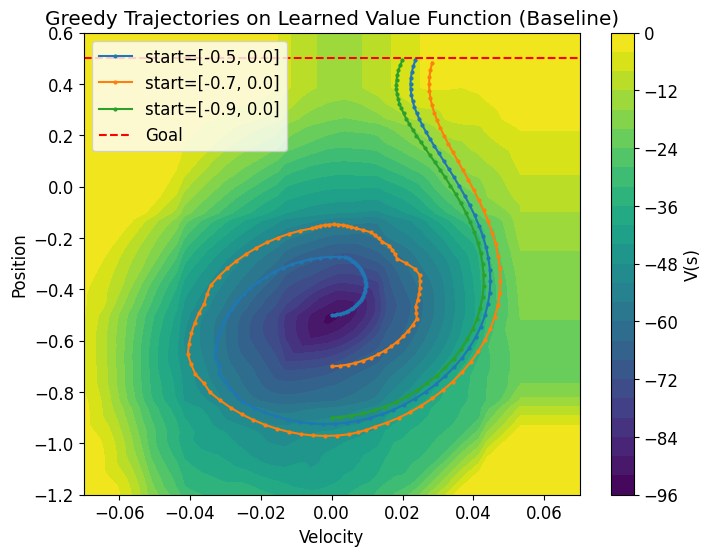

In [10]:
def run_greedy_episode(env, weights, tile_coder, start_state=None, max_steps=500):
    n_actions = weights.shape[0]

    state, info = env.reset()
    if start_state is not None:
        env.unwrapped.state = np.array(start_state, dtype=float)
        state = np.array(start_state, dtype=float)

    positions = []
    velocities = []

    done = False
    steps = 0

    while not done and steps < max_steps:
        positions.append(state[0])
        velocities.append(state[1])

        active = tile_coder.get_active_tiles(state)
        q_vals = [np.sum(weights[a, active]) for a in range(n_actions)]
        action = int(np.argmax(q_vals))

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        steps += 1

    return np.array(positions), np.array(velocities)

def plot_trajectories_on_value(weights, tile_coder, start_states, title="Trajectories on Value Function"):
    positions_grid = np.linspace(-1.2, 0.6, 60)
    velocities_grid = np.linspace(-0.07, 0.07, 60)
    V = compute_q_grid(weights, tile_coder, positions_grid, velocities_grid)

    plt.figure(figsize=(8, 6))
    cs = plt.contourf(velocities_grid, positions_grid, V, levels=30, cmap="viridis")
    plt.colorbar(cs, label="V(s)")
    plt.xlabel("Velocity")
    plt.ylabel("Position")
    plt.title(title)

    env_plot = gym.make("MountainCar-v0")
    for s0 in start_states:
        pos_traj, vel_traj = run_greedy_episode(env_plot, weights, tile_coder,
                                                start_state=s0, max_steps=500)
        plt.plot(vel_traj, pos_traj, marker="o", markersize=2, linewidth=1.5, label=f"start={s0}")

    plt.axhline(0.5, color="red", linestyle="--", label="Goal")
    plt.legend()
    plt.show()
    env_plot.close()

# Example: trajectories from different initial positions
example_starts = [
    [-0.5, 0.0],
    [-0.7, 0.0],
    [-0.9, 0.0],
]
plot_trajectories_on_value(
    weights_baseline,
    baseline_tile_coder,
    example_starts,
    title="Greedy Trajectories on Learned Value Function (Baseline)",
)
